In [121]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Comet Import and Setup

In [122]:
#comet imports
from comet_ml import Experiment

In [123]:
# Import comet_ml at the top of your file, before sklearn!
from comet_ml import Experiment
import os 

# Create an experiment with your api key
comet_exp = Experiment(
    api_key=os.environ.get('COMET_API_KEY'),  # don’t hardcode!!
    project_name="milestone_2",
    workspace="morph-e",
    log_code=True,
)

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data [count]:
COMET INFO:     display_summary_level [2] : 1
COMET INFO:     url [2]                   : https://www.comet.ml/morph-e/milestone-2/50331850708a45f7a6a22f8c7b8d2ac3
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_accuracy [243]             : (0.5663697123527527, 0.6879883408546448)
COMET INFO:     train_auc [243]                  : (0.6751080751419067, 0.7392146587371826)
COMET INFO:     train_batch_accuracy [11907]     : (0.4986454248428345, 0.90234375)
COMET INFO:     train_batch_auc [11907]          : (0.48664534091949463, 0.7892628312110901)
COMET INFO:     train_batch_fn [11907]           : (6.0, 10816.0)
COMET INFO:     train_batch_fp [11907]           : (8.0, 203762.0)
COMET INFO:     train_batch_loss [11907]         : (0.5408026576042175, 1.3990635871887207)
COMET INFO:     train_batch_prc [11907]          : (0.086118

# Imports

In [202]:
#classic
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import tempfile

#project imports
from ift6758.features.feature_engineering2 import SeasonDataSetTwo
from ift6758.metrics import plot_metrics
from ift6758.data.data_acquisition import Season
from ift6758.visualizations.simple_visualization import Utilities 

#sk-learn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, roc_curve, auc)

#keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, preprocessing, activations



In [125]:
#misc
pd.set_option('display.max_columns', None)

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import warnings
warnings.filterwarnings("ignore")

# DATA LOADING

In [126]:
#year selection
train_years = [2015,2016,2017,2018]
test_years=[2019]

In [127]:
train_dataset = SeasonDataSetTwo(train_years)
train_df = train_dataset.get_features_2()

File with all events already Exists, loading from ../ift6758/data/PICKLE//2015_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2015_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2016_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2016_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2017_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2017_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2018_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2018_period_info.pkl


In [128]:
test_data = SeasonDataSetTwo(test_years)
test_df = test_data.get_features_2()

File with all events already Exists, loading from ../ift6758/data/PICKLE//2019_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2019_period_info.pkl


# for Part 7

In [129]:
test_df_regular = test_df[test_df['gamePk'].astype(str).str[5]=='2']
test_df_playoff = test_df[test_df['gamePk'].astype(str).str[5]=='3']

# Split and shuffle

In [130]:
random.seed(42)

In [131]:
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)
#for part 7
test_df_regular = test_df_regular.sample(frac=1)
test_df_playoff = test_df_playoff.sample(frac=1)

In [132]:
train_df.head()

,result.penaltySeverity,result.penaltyMinutes,gamePk,team.name,gamePeriod,coordinatesX,coordinatesY,shotType,emptyNet,result.strength.name,gameSeconds,shotDistance,shotAngle,isGoal,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,timeFromLastEvent,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed
101832,NaN,NaN,2016020291,St. Louis Blues,3,67.0,12.0,Slap Shot,0,NaN,817.0,25.059928,-28.610460,0,Shot,-72.0,-5.0,19.0,140.035710,1,7.370301,12.220919,0.643206
199945,NaN,NaN,2017020463,Detroit Red Wings,2,69.0,-21.0,Snap Shot,0,NaN,1006.0,29.000000,46.397181,0,Shot,-66.0,-4.0,12.0,136.066160,1,11.338847,56.262988,4.688582
329529,NaN,NaN,2018021140,St. Louis Blues,3,81.0,-8.0,Wrist Shot,0,NaN,388.0,11.313708,45.000000,0,Faceoff,69.0,22.0,6.0,32.310989,0,5.385165,0.000000,0.000000
231580,NaN,NaN,2017020954,Chicago Blackhawks,1,-81.0,-2.0,Tip-In,False,Even,88.0,8.246211,-14.036243,1,Shot,36.0,3.0,14.0,117.106789,1,8.364771,10.796543,0.771182
184071,NaN,NaN,2017020215,Chicago Blackhawks,1,-90.0,-6.0,Wrap-around,0,NaN,1103.0,6.082763,-99.462322,0,Hit,92.0,39.0,29.0,187.480666,0,6.464851,0.000000,0.000000


# Preprocessing

In [138]:
features = ['gameSeconds','timeFromLastEvent','gamePeriod','shotType','lastEventType', 'shotAngle', 'shotDistance','distanceFromLastEvent', 'rebound','speed','changeInShotAngle','angleSpeed']
label = ['isGoal']

In [139]:
train_df[features].isna().any()
test_df[features].isna().any()

test_df_regular[features].isna().any()
test_df_playoff[features].isna().any()

gameSeconds              False
timeFromLastEvent        False
gamePeriod               False
shotType                  True
lastEventType            False
shotAngle                False
shotDistance             False
distanceFromLastEvent     True
rebound                  False
speed                     True
changeInShotAngle        False
angleSpeed                True
dtype: bool

In [140]:
#replace inf with nan
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

test_df_regular.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df_playoff.replace([np.inf, -np.inf], np.nan, inplace=True)

In [141]:
#drop rows with nan
train_df = train_df[train_df['shotType'].notna()]
test_df = test_df[test_df['shotType'].notna()]
test_df_regular = test_df_regular[test_df_regular['shotType'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['shotType'].notna()]

train_df = train_df[train_df['shotAngle'].notna()]
test_df = test_df[test_df['shotAngle'].notna()]
test_df_regular = test_df_regular[test_df_regular['shotAngle'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['shotAngle'].notna()]

train_df = train_df[train_df['shotDistance'].notna()]
test_df = test_df[test_df['shotDistance'].notna()]
test_df_regular = test_df_regular[test_df_regular['shotDistance'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['shotDistance'].notna()]

train_df = train_df[train_df['speed'].notna()]
test_df = test_df[test_df['speed'].notna()]
test_df_regular = test_df_regular[test_df_regular['speed'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['speed'].notna()]

train_df = train_df[train_df['changeInShotAngle'].notna()]
test_df = test_df[test_df['changeInShotAngle'].notna()]
test_df_regular = test_df_regular[test_df_regular['changeInShotAngle'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['changeInShotAngle'].notna()]

train_df = train_df[train_df['angleSpeed'].notna()]
test_df = test_df[test_df['angleSpeed'].notna()]
test_df_regular = test_df_regular[test_df_regular['angleSpeed'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['angleSpeed'].notna()]

train_df = train_df[train_df['distanceFromLastEvent'].notna()]
test_df = test_df[test_df['distanceFromLastEvent'].notna()]
test_df_regular = test_df_regular[test_df_regular['distanceFromLastEvent'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['distanceFromLastEvent'].notna()]

In [144]:
#sanity check
train_df[features].isna().any()
test_df[features].isna().any()
test_df_regular[features].isna().any()
test_df_playoff[features].isna().any()

gameSeconds              False
timeFromLastEvent        False
gamePeriod               False
shotType                 False
lastEventType            False
shotAngle                False
shotDistance             False
distanceFromLastEvent    False
rebound                  False
speed                    False
changeInShotAngle        False
angleSpeed               False
dtype: bool

# Categorical Data encoding

In [145]:
from sklearn.preprocessing import OrdinalEncoder

In [146]:
enc = OrdinalEncoder()
enc.fit(train_df[['lastEventType']])

OrdinalEncoder()

In [147]:
train_df[['lastEventType']] = enc.transform(train_df[['lastEventType']]).astype(int)
test_df[['lastEventType']] = enc.transform(test_df[['lastEventType']]).astype(int)

test_df_regular[['lastEventType']] = enc.transform(test_df_regular[['lastEventType']]).astype(int)
test_df_playoff[['lastEventType']] = enc.transform(test_df_playoff[['lastEventType']]).astype(int)

In [148]:
train_df['lastEventType'].unique(),test_df['lastEventType'].unique()

(array([7, 1, 4, 0, 5, 2, 8, 6, 3]), array([1, 7, 8, 4, 2, 0, 5, 6, 3]))

In [149]:
enc = OrdinalEncoder()
enc.fit(train_df[['shotType']])

train_df[['shotType']] = enc.transform(train_df[['shotType']]).astype(int)
test_df[['shotType']] = enc.transform(test_df[['shotType']]).astype(int)

test_df_regular[['shotType']] = enc.transform(test_df_regular[['shotType']]).astype(int)
test_df_playoff[['shotType']] = enc.transform(test_df_playoff[['shotType']]).astype(int)

In [150]:
#Sanity check
train_df['shotType'].unique(), test_df['lastEventType'].unique()

(array([2, 3, 6, 4, 5, 0, 1]), array([1, 7, 8, 4, 2, 0, 5, 6, 3]))

In [152]:
train_df.head()

,result.penaltySeverity,result.penaltyMinutes,gamePk,team.name,gamePeriod,coordinatesX,coordinatesY,shotType,emptyNet,result.strength.name,gameSeconds,shotDistance,shotAngle,isGoal,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,timeFromLastEvent,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed
101832,NaN,NaN,2016020291,St. Louis Blues,3,67.0,12.0,2,0,NaN,817.0,25.059928,-28.610460,0,7,-72.0,-5.0,19.0,140.035710,1,7.370301,12.220919,0.643206
199945,NaN,NaN,2017020463,Detroit Red Wings,2,69.0,-21.0,3,0,NaN,1006.0,29.000000,46.397181,0,7,-66.0,-4.0,12.0,136.066160,1,11.338847,56.262988,4.688582
329529,NaN,NaN,2018021140,St. Louis Blues,3,81.0,-8.0,6,0,NaN,388.0,11.313708,45.000000,0,1,69.0,22.0,6.0,32.310989,0,5.385165,0.000000,0.000000
231580,NaN,NaN,2017020954,Chicago Blackhawks,1,-81.0,-2.0,4,False,Even,88.0,8.246211,-14.036243,1,7,36.0,3.0,14.0,117.106789,1,8.364771,10.796543,0.771182
184071,NaN,NaN,2017020215,Chicago Blackhawks,1,-90.0,-6.0,5,0,NaN,1103.0,6.082763,-99.462322,0,4,92.0,39.0,29.0,187.480666,0,6.464851,0.000000,0.000000


# Feature Selection

In [154]:
train_df[features].head(2)

,gameSeconds,timeFromLastEvent,gamePeriod,shotType,lastEventType,shotAngle,shotDistance,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed
101832,817.0,19.0,3,2,7,-28.610460,25.059928,140.03571,1,7.370301,12.220919,0.643206
199945,1006.0,12.0,2,3,7,46.397181,29.000000,136.06616,1,11.338847,56.262988,4.688582


In [155]:
#take categorical features
non_categorical = ['gameSeconds','timeFromLastEvent','shotAngle','shotDistance','distanceFromLastEvent','speed','changeInShotAngle','angleSpeed']
features_cat = [x for x in features.copy() if x not in non_categorical.copy()]

In [156]:
features_cat

['gamePeriod', 'shotType', 'lastEventType', 'rebound']

In [157]:
#taken from https://medium.com/analytics-vidhya/feature-selection-using-scikit-learn-5b4362e0c19b
from sklearn.feature_selection import SelectKBest, chi2

X_3_best= SelectKBest(chi2, k=3).fit(train_df[features_cat], train_df[label])
mask = X_3_best.get_support() #list of booleans for selected features
new_feat = [] 
for bool, feature in zip(mask, train_df[features_cat].columns):
  if bool:
    new_feat.append(feature)
print("The best features are:{}".format(new_feat)) # The list of your 3 best features

The best features are:['gamePeriod', 'lastEventType', 'rebound']


In [158]:
features_sel = new_feat + non_categorical
print(features_sel)

['gamePeriod', 'lastEventType', 'rebound', 'gameSeconds', 'timeFromLastEvent', 'shotAngle', 'shotDistance', 'distanceFromLastEvent', 'speed', 'changeInShotAngle', 'angleSpeed']


# Split train validation set

In [159]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_df[features].copy(), train_df[label].copy(), test_size=0.25, random_state=42)



#for part 7
X_test_playoff = test_df_playoff[features].copy()
y_test_playoff = test_df_playoff[label].copy()

X_test_regular = test_df_regular[features].copy()
y_test_regular = test_df_regular[label].copy()

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,X_test_regular.shape, y_test_regular.shape, X_test_playoff.shape, y_test_playoff.shape

((248898, 12),
 (248898, 1),
 (82966, 12),
 (82966, 1),
 (66366, 12),
 (66366, 1),
 (7802, 12),
 (7802, 1))

In [160]:
X_test_playoff.head()

,gameSeconds,timeFromLastEvent,gamePeriod,shotType,lastEventType,shotAngle,shotDistance,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed
70435,1186.0,3.0,1,6,2,11.633634,138.852440,42.011903,0,14.003968,0.000000,0.000000
69276,166.0,16.0,4,0,7,-7.961751,144.391828,42.154478,1,2.634655,16.470454,1.029403
72723,322.0,32.0,2,3,4,5.194429,176.725776,21.540659,0,0.673146,0.000000,0.000000
72121,153.0,19.0,4,6,4,-4.763642,168.582324,18.000000,0,0.947368,0.000000,0.000000
75962,6.0,6.0,4,2,1,15.662106,111.126055,34.985711,0,5.830952,0.000000,0.000000


## Normalize numerical columns

In [161]:
num = non_categorical.copy()
print(num)

['gameSeconds', 'timeFromLastEvent', 'shotAngle', 'shotDistance', 'distanceFromLastEvent', 'speed', 'changeInShotAngle', 'angleSpeed']


In [162]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[num])

X_train[num] = scaler.transform(X_train[num])
X_valid[num] = scaler.transform(X_valid[num])
X_test_playoff[num]= scaler.transform(X_test_playoff[num])
X_test_regular[num]=scaler.transform(X_test_regular[num])

In [163]:
X_train.head()

,gameSeconds,timeFromLastEvent,gamePeriod,shotType,lastEventType,shotAngle,shotDistance,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed
168008,0.597418,0.641036,1,0,8,-1.487151,-0.781001,-0.074427,0,-0.559012,-0.364763,-0.234199
55097,0.384890,1.182264,2,2,5,0.128778,0.365853,1.218030,0,-0.436799,-0.364763,-0.234199
243603,-1.372767,-0.103152,1,6,4,-1.852126,-0.705111,-0.951304,0,-0.662611,-0.364763,-0.234199
37866,0.264267,-0.035498,1,3,4,-1.608402,-0.038338,0.793731,0,-0.141905,-0.364763,-0.234199
126717,0.603162,1.655838,3,3,5,-0.071957,-0.256981,0.745879,0,-0.552261,-0.364763,-0.234199


# Imbalnced Data check

Based on the imbalanced data tutorial by tensorflow
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [164]:
y_train.value_counts()

isGoal
0         226410
1          22488
dtype: int64

In [165]:
neg, pos = np.bincount(y_train['isGoal'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 248898
    Positive: 22488 (9.04% of total)



### This means that only ~9% of the data is goals -> unbalanced data 

# Neural Network with KERAS

In [166]:
# convert to tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

test_playoff_ds = tf.data.Dataset.from_tensor_slices((X_test_playoff, y_test_playoff))
test_regular_ds = tf.data.Dataset.from_tensor_slices((X_test_regular, y_test_regular))

In [167]:
for inputs, targets in train_ds.take(2):
    print ('Data: {}, Target: {}'.format(inputs, targets))
    print()

Data: [ 0.59741767  0.64103623  1.          0.          8.         -1.48715114
 -0.7810011  -0.07442705  0.         -0.55901174 -0.36476326 -0.23419933], Target: [0]

Data: [ 0.3848905   1.18226368  2.          2.          5.          0.12877789
  0.36585295  1.2180297   0.         -0.43679873 -0.36476326 -0.23419933], Target: [0]



In [168]:
print(train_ds.cardinality().numpy())

248898


In [169]:
print(val_ds.cardinality().numpy())

82966


In [170]:
BATCH_SIZE = 512

train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

for inputs, targets in train_ds.take(3):
    print('Data: ', inputs.numpy()[:3])
    print('Target: ', targets.numpy()[:3])
    print()

Data:  [[ 0.59741767  0.64103623  1.          0.          8.         -1.48715114
  -0.7810011  -0.07442705  0.         -0.55901174 -0.36476326 -0.23419933]
 [ 0.3848905   1.18226368  2.          2.          5.          0.12877789
   0.36585295  1.2180297   0.         -0.43679873 -0.36476326 -0.23419933]
 [-1.3727667  -0.10315152  1.          6.          4.         -1.85212649
  -0.70511101 -0.95130375  0.         -0.66261102 -0.36476326 -0.23419933]]
Target:  [[0]
 [0]
 [0]]

Data:  [[ 4.59958081e-02 -1.03151518e-01  2.00000000e+00  3.00000000e+00
   7.00000000e+00  1.44191473e+00 -6.27018924e-01  1.10039671e+00
   1.00000000e+00  4.00963457e-03  1.64965756e+00  1.86070323e-01]
 [ 7.78352973e-01 -6.44378970e-01  1.00000000e+00  6.00000000e+00
   1.00000000e+00  8.26817691e-01  8.01017128e-01 -9.93832620e-02
   0.00000000e+00  1.52793942e-01 -3.64763260e-01 -2.34199326e-01]
 [-1.35553477e+00 -9.82646128e-01  1.00000000e+00  3.00000000e+00
   7.00000000e+00 -2.19019503e-01 -9.94658828e-0

In [171]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [172]:
def build_model(metrics=METRICS, output_bias=None):
    
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    model = keras.models.Sequential()
    
    #Input Layer
    model.add(layers.InputLayer(input_shape=(X_train.shape[-1],)))
    
    # first fc layer
    
    model.add(layers.Dense(128, kernel_initializer='lecun_normal', activation='selu'))
    model.add(layers.AlphaDropout(0.1))
      
    model.add(layers.Dense(64, kernel_initializer='lecun_normal', activation='selu'))
    model.add(layers.AlphaDropout(0.1))
    
    model.add(layers.Dense(16, kernel_initializer='lecun_normal', activation='selu'))
    model.add(layers.AlphaDropout(0.1))
    
    
    # Last fc layer 
    # We choose the activation method as a sigmoid to get an output ranging between [0, 1]
    model.add(layers.Dense(1, activation='sigmoid', bias_initializer=output_bias, name='target'))
    
    # Compile The model
    global LEARNING_RATE
    LEARNING_RATE= 1e-2

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss = keras.losses.BinaryCrossentropy(from_logits=False),
              metrics = METRICS)

    return model

### Set the correct initial bias


This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

In [173]:
initial_bias = np.log([pos/neg])
initial_bias

array([-2.30936568])

## Calculate class weights

In [174]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.55
Weight for class 1: 5.53


PS: We use "Adam" optimiser since it's unaffected by the scaling here

In [175]:
#we change it from 50 to 100
EPOCHS = 100

In [176]:
weighted_model = build_model(output_bias=initial_bias)
#weighted_model.load_weights(initial_weights)

print(weighted_model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 128)               1664      
                                                                 
 alpha_dropout_21 (AlphaDrop  (None, 128)              0         
 out)                                                            
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 alpha_dropout_22 (AlphaDrop  (None, 64)               0         
 out)                                                            
                                                                 
 dense_23 (Dense)            (None, 16)                1040      
                                                                 
 alpha_dropout_23 (AlphaDrop  (None, 16)              

In [177]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    patience=10, 
    verbose=1, 
    mode='max',
    restore_best_weights=True)

In [178]:
with comet_exp.train():
    weighted_history = weighted_model.fit(
    x=train_ds,
    epochs=EPOCHS,
    #callbacks=[stop_early],
    validation_data=val_ds,
    # class weights
    class_weight=class_weight)

Epoch 1/100
487/487 [==============================] - 8s 12ms/step - loss: 0.6558 - tp: 13979.0000 - fp: 83044.0000 - tn: 143366.0000 - fn: 8509.0000 - accuracy: 0.6322 - precision: 0.1441 - recall: 0.6216 - auc: 0.6690 - prc: 0.1555 - val_loss: 0.8122 - val_tp: 6242.0000 - val_fp: 40271.0000 - val_tn: 35194.0000 - val_fn: 1259.0000 - val_accuracy: 0.4994 - val_precision: 0.1342 - val_recall: 0.8322 - val_auc: 0.7141 - val_prc: 0.1874
Epoch 2/100
487/487 [==============================] - 4s 8ms/step - loss: 0.6270 - tp: 15541.0000 - fp: 86385.0000 - tn: 140025.0000 - fn: 6947.0000 - accuracy: 0.6250 - precision: 0.1525 - recall: 0.6911 - auc: 0.7049 - prc: 0.1769 - val_loss: 0.8501 - val_tp: 6304.0000 - val_fp: 40507.0000 - val_tn: 34958.0000 - val_fn: 1197.0000 - val_accuracy: 0.4973 - val_precision: 0.1347 - val_recall: 0.8404 - val_auc: 0.7220 - val_prc: 0.1964
Epoch 3/100
487/487 [==============================] - 4s 8ms/step - loss: 0.6229 - tp: 15598.0000 - fp: 85585.0000 - tn:

487/487 [==============================] - 4s 8ms/step - loss: 0.6113 - tp: 16434.0000 - fp: 87838.0000 - tn: 138572.0000 - fn: 6054.0000 - accuracy: 0.6228 - precision: 0.1576 - recall: 0.7308 - auc: 0.7269 - prc: 0.2022 - val_loss: 0.8424 - val_tp: 6280.0000 - val_fp: 38446.0000 - val_tn: 37019.0000 - val_fn: 1221.0000 - val_accuracy: 0.5219 - val_precision: 0.1404 - val_recall: 0.8372 - val_auc: 0.7384 - val_prc: 0.2211
Epoch 20/100
487/487 [==============================] - 4s 9ms/step - loss: 0.6105 - tp: 16402.0000 - fp: 86812.0000 - tn: 139598.0000 - fn: 6086.0000 - accuracy: 0.6268 - precision: 0.1589 - recall: 0.7294 - auc: 0.7283 - prc: 0.2033 - val_loss: 0.9110 - val_tp: 6140.0000 - val_fp: 36679.0000 - val_tn: 38786.0000 - val_fn: 1361.0000 - val_accuracy: 0.5415 - val_precision: 0.1434 - val_recall: 0.8186 - val_auc: 0.7362 - val_prc: 0.2180
Epoch 21/100
487/487 [==============================] - 4s 7ms/step - loss: 0.6123 - tp: 16400.0000 - fp: 87352.0000 - tn: 139058.000

Epoch 38/100
487/487 [==============================] - 5s 10ms/step - loss: 0.6098 - tp: 16228.0000 - fp: 84855.0000 - tn: 141555.0000 - fn: 6260.0000 - accuracy: 0.6339 - precision: 0.1605 - recall: 0.7216 - auc: 0.7299 - prc: 0.2030 - val_loss: 0.8320 - val_tp: 6161.0000 - val_fp: 36426.0000 - val_tn: 39039.0000 - val_fn: 1340.0000 - val_accuracy: 0.5448 - val_precision: 0.1447 - val_recall: 0.8214 - val_auc: 0.7416 - val_prc: 0.2232
Epoch 39/100
487/487 [==============================] - 4s 7ms/step - loss: 0.6072 - tp: 16509.0000 - fp: 86896.0000 - tn: 139514.0000 - fn: 5979.0000 - accuracy: 0.6269 - precision: 0.1597 - recall: 0.7341 - auc: 0.7320 - prc: 0.2054 - val_loss: 0.8080 - val_tp: 5974.0000 - val_fp: 34035.0000 - val_tn: 41430.0000 - val_fn: 1527.0000 - val_accuracy: 0.5714 - val_precision: 0.1493 - val_recall: 0.7964 - val_auc: 0.7405 - val_prc: 0.2237
Epoch 40/100
487/487 [==============================] - 4s 7ms/step - loss: 0.6073 - tp: 16467.0000 - fp: 86210.0000 - 

Epoch 57/100
487/487 [==============================] - 3s 7ms/step - loss: 0.6064 - tp: 16456.0000 - fp: 85526.0000 - tn: 140884.0000 - fn: 6032.0000 - accuracy: 0.6321 - precision: 0.1614 - recall: 0.7318 - auc: 0.7335 - prc: 0.2089 - val_loss: 0.6958 - val_tp: 5791.0000 - val_fp: 31334.0000 - val_tn: 44131.0000 - val_fn: 1710.0000 - val_accuracy: 0.6017 - val_precision: 0.1560 - val_recall: 0.7720 - val_auc: 0.7431 - val_prc: 0.2260
Epoch 58/100
487/487 [==============================] - 3s 7ms/step - loss: 0.6048 - tp: 16518.0000 - fp: 86100.0000 - tn: 140310.0000 - fn: 5970.0000 - accuracy: 0.6301 - precision: 0.1610 - recall: 0.7345 - auc: 0.7350 - prc: 0.2110 - val_loss: 0.7333 - val_tp: 5992.0000 - val_fp: 33975.0000 - val_tn: 41490.0000 - val_fn: 1509.0000 - val_accuracy: 0.5723 - val_precision: 0.1499 - val_recall: 0.7988 - val_auc: 0.7424 - val_prc: 0.2248
Epoch 59/100
487/487 [==============================] - 4s 8ms/step - loss: 0.6046 - tp: 16588.0000 - fp: 86516.0000 - t

487/487 [==============================] - 4s 7ms/step - loss: 0.6047 - tp: 16576.0000 - fp: 86609.0000 - tn: 139801.0000 - fn: 5912.0000 - accuracy: 0.6283 - precision: 0.1606 - recall: 0.7371 - auc: 0.7345 - prc: 0.2116 - val_loss: 0.5581 - val_tp: 5203.0000 - val_fp: 25193.0000 - val_tn: 50272.0000 - val_fn: 2298.0000 - val_accuracy: 0.6686 - val_precision: 0.1712 - val_recall: 0.6936 - val_auc: 0.7428 - val_prc: 0.2249
Epoch 76/100
487/487 [==============================] - 4s 8ms/step - loss: 0.6044 - tp: 16664.0000 - fp: 86946.0000 - tn: 139464.0000 - fn: 5824.0000 - accuracy: 0.6273 - precision: 0.1608 - recall: 0.7410 - auc: 0.7353 - prc: 0.2117 - val_loss: 0.5712 - val_tp: 5284.0000 - val_fp: 25823.0000 - val_tn: 49642.0000 - val_fn: 2217.0000 - val_accuracy: 0.6620 - val_precision: 0.1699 - val_recall: 0.7044 - val_auc: 0.7442 - val_prc: 0.2262
Epoch 77/100
487/487 [==============================] - 4s 8ms/step - loss: 0.6045 - tp: 16786.0000 - fp: 87829.0000 - tn: 138581.000

Epoch 94/100
487/487 [==============================] - 3s 7ms/step - loss: 0.6027 - tp: 16642.0000 - fp: 87571.0000 - tn: 138839.0000 - fn: 5846.0000 - accuracy: 0.6247 - precision: 0.1597 - recall: 0.7400 - auc: 0.7365 - prc: 0.2134 - val_loss: 0.5961 - val_tp: 5285.0000 - val_fp: 25958.0000 - val_tn: 49507.0000 - val_fn: 2216.0000 - val_accuracy: 0.6604 - val_precision: 0.1692 - val_recall: 0.7046 - val_auc: 0.7422 - val_prc: 0.2266
Epoch 95/100
487/487 [==============================] - 3s 7ms/step - loss: 0.6029 - tp: 16743.0000 - fp: 87332.0000 - tn: 139078.0000 - fn: 5745.0000 - accuracy: 0.6260 - precision: 0.1609 - recall: 0.7445 - auc: 0.7369 - prc: 0.2131 - val_loss: 0.5525 - val_tp: 4955.0000 - val_fp: 23298.0000 - val_tn: 52167.0000 - val_fn: 2546.0000 - val_accuracy: 0.6885 - val_precision: 0.1754 - val_recall: 0.6606 - val_auc: 0.7406 - val_prc: 0.2256
Epoch 96/100
487/487 [==============================] - 3s 7ms/step - loss: 0.6022 - tp: 16732.0000 - fp: 88301.0000 - t

In [179]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

In [180]:
weighted_model.metrics_names

['loss',
 'tp',
 'fp',
 'tn',
 'fn',
 'accuracy',
 'precision',
 'recall',
 'auc',
 'prc']

{'web': 'https://www.comet.ml/api/image/download?imageId=096b5865c120471285fdfccf6abb982e&experimentKey=4fe58590ba824e9489108f24d576b56b',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=096b5865c120471285fdfccf6abb982e&experimentKey=4fe58590ba824e9489108f24d576b56b',
 'imageId': '096b5865c120471285fdfccf6abb982e'}

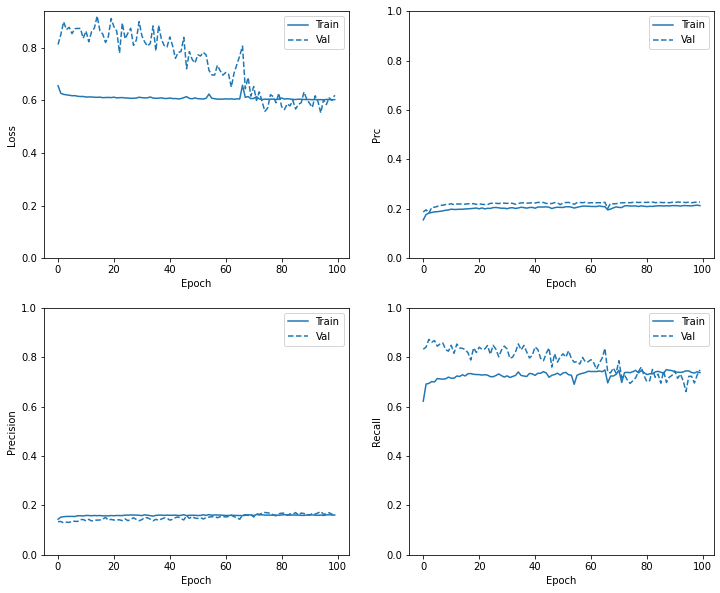

In [181]:
plot_metrics(weighted_history)
comet_exp.log_figure(figure=plt)

In [182]:
results = weighted_model.evaluate(val_ds)

for name, value in zip(weighted_model.metrics_names, results):
    print(name, ': ', value)
print()

163/163 [==============================] - 1s 3ms/step - loss: 0.6201 - tp: 5613.0000 - fp: 29696.0000 - tn: 45769.0000 - fn: 1888.0000 - accuracy: 0.6193 - precision: 0.1590 - recall: 0.7483 - auc: 0.7425 - prc: 0.2275
loss :  0.6200566291809082
tp :  5613.0
fp :  29696.0
tn :  45769.0
fn :  1888.0
accuracy :  0.6193139553070068
precision :  0.1589679718017578
recall :  0.7483002543449402
auc :  0.7424807548522949
prc :  0.22753770649433136



In [183]:
y_proba_val = weighted_model.predict(val_ds, verbose=1)

163/163 [==============================] - 1s 3ms/step


In [184]:
y_proba_val = np.concatenate([y for y in y_proba_val], axis=0)
y_proba_val

array([0.5545428 , 0.74108934, 0.5034484 , ..., 0.1455465 , 0.18444324,
       0.707229  ], dtype=float32)

In [185]:
threshold = 0.5
y_pred_val = np.where(y_proba_val > threshold, 1,0)

In [186]:
y_pred_val.sum()

35309

In [187]:
val_y_true = np.concatenate([y for x, y in val_ds], axis=0)

In [188]:
val_y_true.sum()

7501

# Prepare for Comet Logs

In [189]:
#these will all get logged
params={'batch_size':BATCH_SIZE,
        'epochs':EPOCHS,
        'layer_num':4,
        'optimizer':'adam',
        'learning_rate':LEARNING_RATE
}

In [190]:
#will log metrics with the prefix 'test_'
# with experiment.test():
#     results = model.evaluate(x_test, y_test)
    
#     experiment.log_metrics(metrics)

In [191]:
# results = weighted_model.evaluate(test_ds)
# for name, value in zip(weighted_model.metrics_names, results):
#     print(name, ': ', value)

In [192]:
comet_exp.log_parameters(params)

In [193]:
# weights_dir = "../ift6758/models/weights"
# experiment = "Neural-Net-with-FE2"
# predscore_val_dict={}

In [203]:
# import joblib

# predscore_val_dict[experiment]={}
# predscore_val_dict[experiment]['true_valid_label']=y_valid
# predscore_val_dict[experiment]['proba']=y_proba_val
# predscore_val_dict[experiment]['prediction']=y_pred_val

# ## Dumping model
# filename=f"{weights_dir}/{experiment}.pkl"
# filename
# joblib.dump(model,filename)

## Plotting

              precision    recall  f1-score   support

           0       0.96      0.61      0.74     75465
           1       0.16      0.75      0.26      7501

    accuracy                           0.62     82966
   macro avg       0.56      0.68      0.50     82966
weighted avg       0.89      0.62      0.70     82966



{'web': 'https://www.comet.ml/api/image/download?imageId=2255187f8dbf4f058aafa4ccd4827af3&experimentKey=4fe58590ba824e9489108f24d576b56b',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=2255187f8dbf4f058aafa4ccd4827af3&experimentKey=4fe58590ba824e9489108f24d576b56b',
 'imageId': '2255187f8dbf4f058aafa4ccd4827af3'}

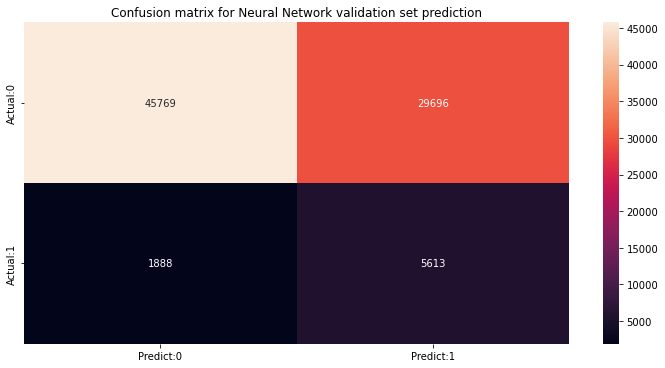

In [204]:
from ift6758.metrics import plot_metrics
img_path = os.path.join(tempfile.mkdtemp(), 'imgs')

plot_metrics.plotConfusion(val_y_true,y_pred_val, title='Confusion matrix for Neural Network validation set prediction')
comet_exp.log_figure(figure=plt)

{'web': 'https://www.comet.ml/api/image/download?imageId=671d0cdce4a142c2b4b0758672b64d7c&experimentKey=4fe58590ba824e9489108f24d576b56b',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=671d0cdce4a142c2b4b0758672b64d7c&experimentKey=4fe58590ba824e9489108f24d576b56b',
 'imageId': '671d0cdce4a142c2b4b0758672b64d7c'}

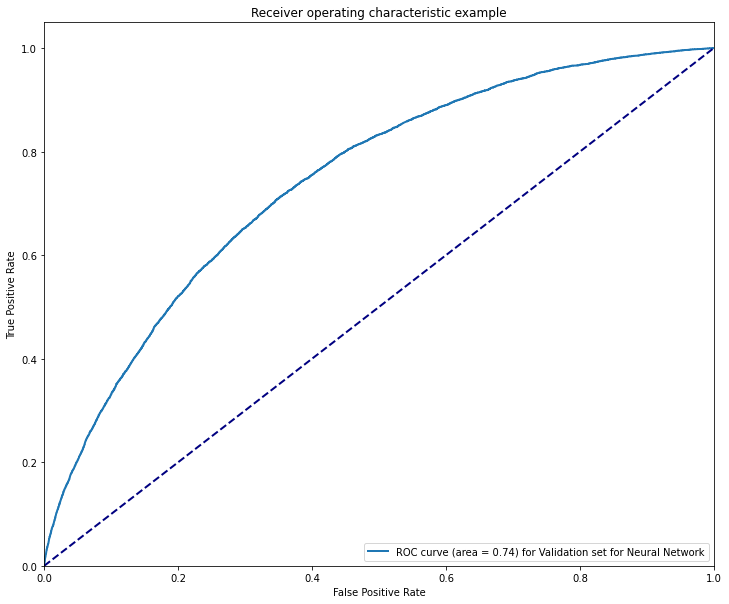

In [206]:
plot_metrics.plot_roc([val_y_true],[y_proba_val],["Validation set for Neural Network"])
comet_exp.log_figure(figure=plt)

{'web': 'https://www.comet.ml/api/image/download?imageId=def028bedb364e41abe156c4d35858d7&experimentKey=4fe58590ba824e9489108f24d576b56b',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=def028bedb364e41abe156c4d35858d7&experimentKey=4fe58590ba824e9489108f24d576b56b',
 'imageId': 'def028bedb364e41abe156c4d35858d7'}

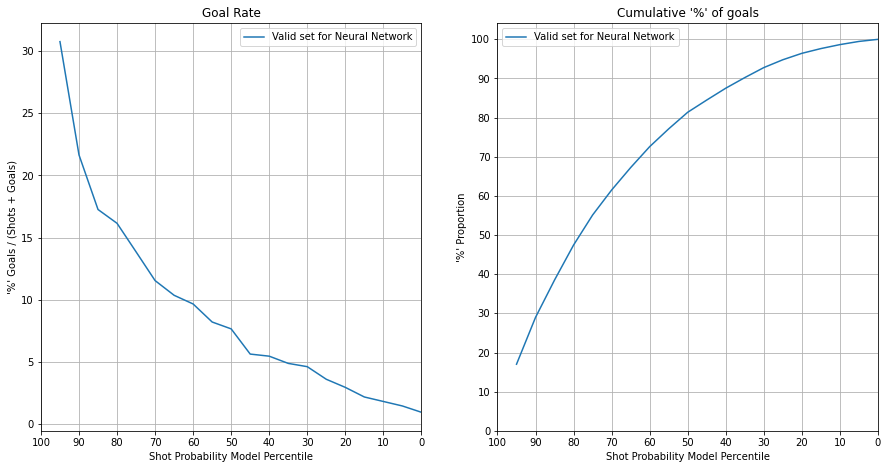

In [207]:
plot_metrics.plot_percentile([val_y_true],[y_proba_val],bin_width=5,plot_labels=["Valid set for Neural Network"])
comet_exp.log_figure(figure=plt)

{'web': 'https://www.comet.ml/api/image/download?imageId=a6c1dfd1d91e476281e260a4e0f2be7e&experimentKey=4fe58590ba824e9489108f24d576b56b',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=a6c1dfd1d91e476281e260a4e0f2be7e&experimentKey=4fe58590ba824e9489108f24d576b56b',
 'imageId': 'a6c1dfd1d91e476281e260a4e0f2be7e'}

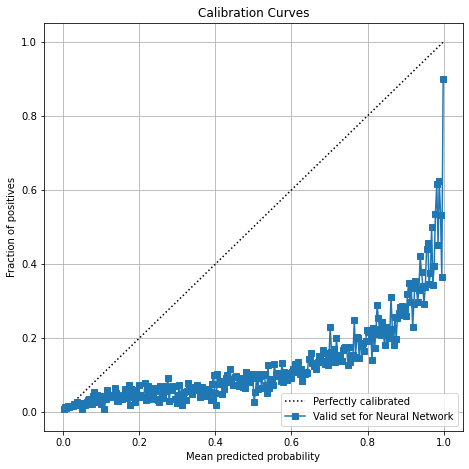

In [208]:
plot_metrics.plot_calibration([val_y_true],[y_proba_val],plot_labels=["Valid set for Neural Network"])
comet_exp.log_figure(figure=plt)